# Transition Matrix for CECL PD calculation : 

### Brief processflow followed :
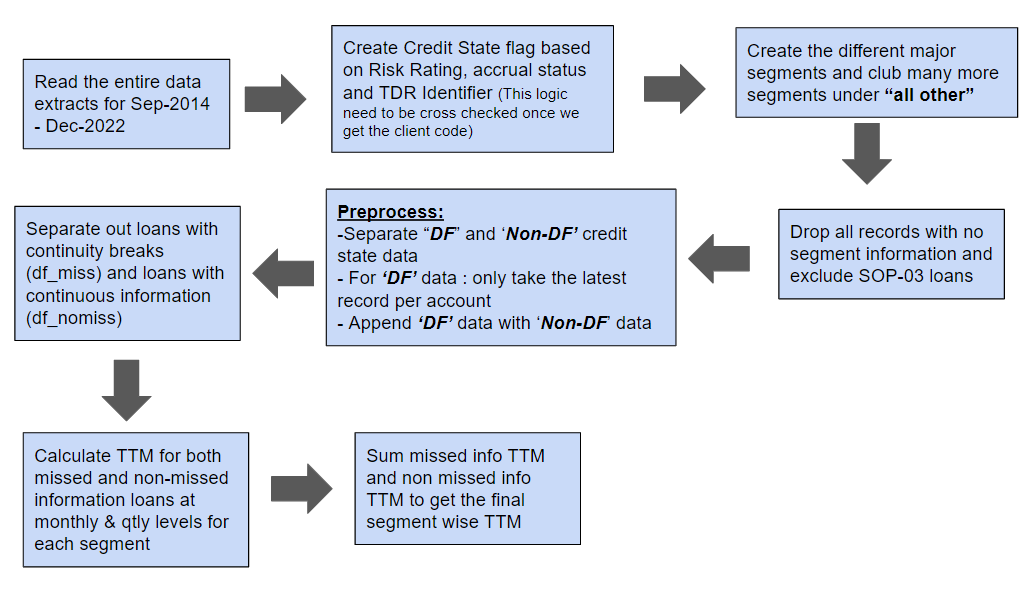

In [1]:
import pandas as pd
import numpy as np
import os

os.chdir(r"C:\Users\kghatak003\Desktop\Work\RABO_CECL_Implementation_May_2023\Rabo AgriFinance 2022\PBCs")

df_extracts = pd.read_excel("Data_Extracts_PwC for RAF Production for Sep-2014 - Dec-2022.xlsx", sheet_name='Export')

df_extracts.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918771 entries, 0 to 918770
Data columns (total 13 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   As Of Date                         918771 non-null  datetime64[ns]
 1   Loan Number/Loan ID                918771 non-null  object        
 2   Accrual Status                     899195 non-null  object        
 3   ALLL Group                         466738 non-null  object        
 4   Bank Book Balance Current per G/L  918771 non-null  float64       
 5   Class 2                            452029 non-null  float64       
 6   Current Year                       452029 non-null  object        
 7   FAS114 Relationship Indicator      466742 non-null  object        
 8   Obligation SOP                     244279 non-null  object        
 9   Product Type                       918771 non-null  object        
 10  Risk Rating         

In [2]:
# Convert the "Risk Rating”s to “Credit State” in the following manner first define the non-default state 
# then define the defaulted ones based on certain criterion

df_extracts["Risk Rating"] = df_extracts["Risk Rating"].str.lower()

df_extracts["Credit_State"] = np.where(df_extracts["Risk Rating"].isin(['good', 'watch']),
                                       "Pass", np.where(df_extracts["Risk Rating"].isin(['olem']),
                                                        "Special Mention", df_extracts["Risk Rating"]))


df_extracts["Credit_State"] = np.where((df_extracts["TDR Flag"] == "Y") | 
                                       ((df_extracts["Accrual Status"].isna()) & 
                                        (df_extracts["Risk Rating"].isin(['substandard','doubtful', 'loss']))), "DF", 
                                       df_extracts["Credit_State"])


print(df_extracts["Risk Rating"].value_counts())

print("\n")

print(df_extracts["Credit_State"].value_counts())

good           744842
watch           79951
substandard     47304
olem            41708
doubtful         4822
loss              144
Name: Risk Rating, dtype: int64


Pass               824656
Special Mention     41612
substandard         33273
DF                  18669
doubtful              561
Name: Credit_State, dtype: int64


In [3]:
# Excluded SOP-03 loans from the transition matrix calculation ("Obligation SOP" = "Y")
df_extracts_upd = df_extracts[df_extracts["Obligation SOP"] != "Y"]
len(df_extracts_upd)

916999

#### For transition matrix calculation we just need the timeline, loan or account number, segment and Credit state. Hence it makes sense to get rid of all unwanted columns.

In [4]:
df_extracts_upd = df_extracts_upd.filter(["Loan Number/Loan ID", "As Of Date", "ALLL Group", "Credit_State"])
df_extracts_upd.head()

,Loan Number/Loan ID,As Of Date,ALLL Group,Credit_State
0,10001200,2014-09-30,Nursery/Greenhouses,substandard
1,10001400,2014-09-30,Nursery/Greenhouses,substandard
2,10001500,2014-09-30,Nursery/Greenhouses,substandard
3,10001600,2014-09-30,Nursery/Greenhouses,substandard
4,10001800,2014-09-30,Cattle Ranching and Farming,Pass


In [5]:
## Check for presence of missing values in any of the above columns: 

df_extracts_upd.isnull().sum()

Loan Number/Loan ID         0
As Of Date                  0
ALLL Group             452033
Credit_State                0
dtype: int64

### Since we are going to build segment wise TTM matrix; hence any missing information on the ALLL Group or model segment should be dropped.

In [6]:

## Drop all the observations for which there is no ALLL Group or segment present in the data:

df_extracts_upd = df_extracts_upd.dropna(subset = ["ALLL Group"])
df_extracts_upd["ALLL Group"].value_counts()

Grains, Oilseeds, and Other Row Crops             158926
Dairy                                              55434
Cattle Ranching and Farming                        44203
Poultry                                            33684
Potatoes                                           22294
Feedlots                                           21172
Tree Nuts                                          19385
Swine                                              15515
Other Fruits & Vegetables (excluding potatoes)     13470
Cotton                                             12216
Tree Fruit                                          9358
Hay                                                 9239
Vineyards and Grapes                                8196
Crop Processing, Merchandising, and Milling         7435
Other                                               6305
Nursery/Greenhouses                                 5407
Investors- Ag and Non-Ag                            2832
Sugar                          

### Since we have too many ALLL segments, we can't model all of them. Based on the guideline from RAF: the ALLL Groups or model segments are clubbed as below.

In [7]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

df_extracts_upd["ALLL Group"] = df_extracts_upd["ALLL Group"].str.lower()
alll_list = ["dairy", "grains, oilseeds, and other row crops", "cattle ranching and farming",
             "feedlots", "tree nuts", "poultry", "potatoes", "vineyards and grapes",
             "other fruits & vegetables (excluding potatoes)", "crop processing, merchandising, and milling",
             "tree fruit", "swine"]

df_extracts_upd["ALLL Group"] = np.where(~(df_extracts_upd["ALLL Group"].isin(alll_list)),"all other", df_extracts_upd["ALLL Group"])
alll_list.append("all other")
df_extracts_upd["ALLL Group"].value_counts()

grains, oilseeds, and other row crops             160315
dairy                                              56165
all other                                          49875
cattle ranching and farming                        44608
poultry                                            33933
potatoes                                           22478
feedlots                                           21586
tree nuts                                          20600
swine                                              15653
other fruits & vegetables (excluding potatoes)     14046
tree fruit                                          9407
vineyards and grapes                                8346
crop processing, merchandising, and milling         7954
Name: ALLL Group, dtype: int64

### We now create a list of possible Credit states. "PO" or "Paid Off" is another state that is added by us, considering the facts that if a loan doesn't belong to any of the other 5 categories, it can be assumed that the loan is paid off or "PO"

In [8]:
states = ["Pass", "Special Mention", "substandard", "doubtful", "DF", "PO"]
date_list = df_extracts["As Of Date"].value_counts().index.to_list()
date_list.sort()

In [11]:
## Sort the dataframe by Date:

df_extracts_upd.reset_index(inplace=True)
df_extracts_upd.drop(columns = ["index"], inplace=True)


df_extracts_upd.sort_values(by=["As Of Date"],ascending=[True], inplace=True)



In [9]:
display(df_extracts_upd.head())

print("\n")

print("length of the final TTM Modelling data :", len(df_extracts_upd))

print("\n")

print("Cross tabulation of the different Credit states in the final modelling data:")
print(df_extracts_upd['Credit_State'].value_counts())



,Loan Number/Loan ID,As Of Date,ALLL Group,Credit_State
0,10001200,2014-09-30,all other,substandard
1,10001400,2014-09-30,all other,substandard
2,10001500,2014-09-30,all other,substandard
3,10001600,2014-09-30,all other,substandard
4,10001800,2014-09-30,cattle ranching and farming,Pass




length of the final TTM Modelling data : 464966


Cross tabulation of the different Credit states in the final modelling data:
Pass               376006
Special Mention     41606
substandard         32790
DF                  14003
doubtful              561
Name: Credit_State, dtype: int64


Now that the final modelling data set is ready we will proceed towards the pre processing , handling of discontinued loans and then will finally build the TTMs both at monthly and quarterly level

## Define functions one by one: 

### preprocessing() : This function does the following job :
        
- Split the data into two subsets with one of them having all the instances with Credit State as "DF" and another one having all the other Credit States.
- For the DF data set, sort the data with Loan number and date. 
- Once sorted keep only the first instance of each loan from the default (DF) dataset.
- For the sorted default or DF dataset with Loan ID & Date and then kept only the first instances of each loan and remove any subsequent instances of a loan if the default state has reached
- Appended resulted DF Dataset from step 7.b. back with  Non-DF dataset as separated in step 7.a.


#### Why are we dedupping the defaulted loans only and not the non-defaulted ones ?
- For the defaulted loans we are only taking the first result. As it is an assumption that if a loan has defaulted it will stay default position only. If the loan changes its status to any non defaulting state then that would anyway get captured from the non-defaulted dataset , which is not deduped. 

- A default is considered to be s terminal state. So, whenever a loan account reaches a default status it is expected that there is no coming back. In the subsequent data processing under the missing_treatmennt() function also we will see that whenever a loan reaches a default state it is flagged and all the subsequent occurance of that loan are dropped from the data set.


In [10]:


def preprocessing(df_extracts):

    df_extracts_DF = df_extracts[df_extracts["Credit_State"] == "DF"]
    df_extracts_NotDF = df_extracts[df_extracts["Credit_State"] != "DF"]

    df_extracts_DF.sort_values(by=["Loan Number/Loan ID", "As Of Date"],ascending=[True, True], inplace=True)
    df_extracts_DF.drop_duplicates(["Loan Number/Loan ID"], inplace=True) ## Commented out on 15th May to generate Account level TTM

    df_extracts_upd = pd.concat([df_extracts_NotDF, df_extracts_DF], axis=0)
    df_extracts_upd.sort_values(by=["Loan Number/Loan ID", "As Of Date"],ascending=[True, True], inplace=True)
    df_extracts_upd.reset_index(inplace=True)
    df_extracts_upd.drop(columns = ["index"], inplace=True)
    
    return df_extracts_upd

In [11]:
df_extracts_upd_processesd=preprocessing(df_extracts_upd)
df_extracts_upd_processesd

,Loan Number/Loan ID,As Of Date,ALLL Group,Credit_State
0,10001200,2014-09-30,all other,substandard
1,10001200,2014-10-31,all other,substandard
2,10001200,2014-11-30,all other,substandard
3,10001200,2014-12-31,all other,substandard
4,10001200,2015-01-31,all other,substandard
...,...,...,...,...
451799,99243800,2015-01-31,"grains, oilseeds, and other row crops",Pass
451800,99243800,2015-02-28,"grains, oilseeds, and other row crops",Pass
451801,99243800,2015-03-31,"grains, oilseeds, and other row crops",Pass
451802,99243800,2015-04-30,"grains, oilseeds, and other row crops",Pass


In [24]:
df = df_extracts_upd_processesd.copy()

## check if the shifted the credit_state by one place =="DF" and the two subsequent loan number remain same then the flag is =1
## This process is done to check if and how many times an account has remained defualted in consecutive months

## the process creates a default identifier and once a loan is defaulted no subsequent records are considered.

df['flag'] = np.where((df['Credit_State'].shift()=='DF') & (df['Loan Number/Loan ID'] == df['Loan Number/Loan ID'].shift()), 1, 0)
df['flag1'] = df.groupby('Loan Number/Loan ID')['flag'].transform(pd.Series.cumsum)

df = df[df['flag1'] != 1]
df.drop(columns = ["flag", "flag1"], inplace=True)

## Check the differnece of dates:
df['lag_flag'] = (df["As Of Date"] - df["As Of Date"].shift())

df_nonnull = df[pd.notnull(df['lag_flag'])]
df_null = df[~(pd.notnull(df['lag_flag']))]

df_null['lag_flag'].value_counts()

df_null['lag_flag'] = 0
df_nonnull['lag_flag'] = df_nonnull['lag_flag'].dt.days.astype('int')
df = pd.concat([df_null, df_nonnull], axis=0)

## For the same loan account check if the continuity breaks (i.e. subseuent occurance is more than 31 days). 
# If the continuity breaks then the loan has a missing information flag.
df['miss_flag'] = np.where((df['lag_flag'] > 31) & (df["Loan Number/Loan ID"] == df["Loan Number/Loan ID"].shift()), 1, 0)

# Store the loan number with missing information in a list
miss_list = df[df['miss_flag'] == 1]["Loan Number/Loan ID"].value_counts().index.to_list()
print("number of loans with missing info :", len(miss_list))

## Curve out two separate dataframes : one with missing loan infromation and the other with no missing loan info    
df_miss = df[df["Loan Number/Loan ID"].isin(miss_list)]
print("length of df with missing loan info: ", len(df_miss))
df_nomiss = df[~(df["Loan Number/Loan ID"].isin(miss_list))]
print("length of df with no missing loan info: ",len(df_nomiss))

## For the data frame with missing info loans assign a flag that checks whether two subsequent loans have same id or not
df_miss['flag'] = (df_miss["Loan Number/Loan ID"] != df_miss["Loan Number/Loan ID"].shift()).astype(int)
df_miss.reset_index(inplace=True)
df_miss.drop(columns = ["index"], inplace=True)
display(df_miss)

df_miss1=df_miss.copy()




for i in range(len(df_miss1)):
    if df_miss1.iloc[i,6] != 1:
        df_miss1.iloc[i,6] = df_miss1.iloc[(i-1),6]+1
        
df_miss1.to_csv("C:\\Users\\kghatak003\\Desktop\\Work\\RABO_CECL_Implementation_May_2023\\Rabo AgriFinance 2022\\df_miss1_new.csv")
        
# df_miss1.drop(columns=["As Of Date", "lag_flag", "miss_flag"],inplace=True)
# df_miss1.rename(columns={'flag': "As Of Date"},inplace=True)
# df_nomiss.reset_index(inplace=True)
# df_nomiss.drop(columns=["lag_flag", "miss_flag", "index"],inplace=True)

# miss_date_list = df_miss1["As Of Date"].value_counts().index.to_list()
# miss_date_list.sort()
    
    
# display(df_miss1)
# display(df_nomiss)

# print(miss_date_list)

# df_nomiss["As Of Date"].value_counts()


## KG Trial check : 

# curr_mnth = df_miss1[df_miss1["As Of Date"]==80].copy()
# next_mnth = df_miss1[df_miss1["As Of Date"]==81].copy()
# curr_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)
# next_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)

# joined = pd.merge(next_mnth, curr_mnth, how="outer", on=["Loan Number/Loan ID"], suffixes=(str('_month_2'),str('_month_1')))


# joined.to_csv("C:\\Users\\kghatak003\\Desktop\\Work\\RABO_CECL_Implementation_May_2023\\Rabo AgriFinance 2022\\df_miss1.csv")
# miss_list

# df


# df[df['Loan Number/Loan ID']=='10021000']
# df[df['Loan Number/Loan ID'].isin(['10001200','22111789'])].sort_values(by='Loan Number/Loan ID')
# df[df['miss_flag']==1]
    
# df[df['lag_flag']>'31 days']
# df[df['flag1'] > 1]
# df[df['Loan Number/Loan ID']=='10005300']
# df

number of loans with missing info : 430
length of df with missing loan info:  17149
length of df with no missing loan info:  431698


,Loan Number/Loan ID,As Of Date,ALLL Group,Credit_State,lag_flag,miss_flag,flag
0,10025500,2014-09-30,"grains, oilseeds, and other row crops",Pass,-2588,0,1
1,10025500,2014-10-31,"grains, oilseeds, and other row crops",Pass,31,0,0
2,10025500,2014-11-30,"grains, oilseeds, and other row crops",Pass,30,0,0
3,10025500,2014-12-31,"grains, oilseeds, and other row crops",Pass,31,0,0
4,10025500,2015-01-31,"grains, oilseeds, and other row crops",Pass,31,0,0
...,...,...,...,...,...,...,...
17144,50031400,2018-01-31,all other,Pass,31,0,0
17145,50031400,2018-02-28,all other,Pass,28,0,0
17146,50031400,2018-03-31,all other,Pass,31,0,0
17147,50031400,2018-04-30,all other,Pass,30,0,0


In [97]:
def missing_treatment(df_raw):

    df = df_raw.copy()
    
    df['flag'] = np.where((df['Credit_State'].shift()=='DF') & (df['Loan Number/Loan ID'] == df['Loan Number/Loan ID'].shift()), 1, 0)
    df['flag1'] = df.groupby('Loan Number/Loan ID')['flag'].transform(pd.Series.cumsum)
    df = df[df['flag1'] != 1]
    df.drop(columns = ["flag", "flag1"], inplace=True)

    df['lag_flag'] = (df["As Of Date"] - df["As Of Date"].shift())
    
    df_nonnull = df[pd.notnull(df['lag_flag'])]
    df_null = df[~(pd.notnull(df['lag_flag']))]
    
    df_null['lag_flag'] = 0
    df_nonnull['lag_flag'] = df_nonnull['lag_flag'].dt.days.astype('int')
    df = pd.concat([df_null, df_nonnull], axis=0)
    
    df['miss_flag'] = np.where((df['lag_flag'] > 31) & (df["Loan Number/Loan ID"] == df["Loan Number/Loan ID"].shift()), 1, 0)
    
    miss_list = df[df['miss_flag'] == 1]["Loan Number/Loan ID"].value_counts().index.to_list()
    
    df_miss = df[df["Loan Number/Loan ID"].isin(miss_list)]
    df_nomiss = df[~(df["Loan Number/Loan ID"].isin(miss_list))]

    df_miss['flag'] = (df_miss["Loan Number/Loan ID"] != df_miss["Loan Number/Loan ID"].shift()).astype(int)
    df_miss.reset_index(inplace=True)
    df_miss.drop(columns = ["index"], inplace=True)
    
    for i in range(len(df_miss)):
        if df_miss.iloc[i,6] != 1:
            df_miss.iloc[i,6] = df_miss.iloc[(i-1),6]+1
    
    df_miss.drop(columns=["As Of Date", "lag_flag", "miss_flag"],inplace=True)
    df_miss.rename(columns={'flag': "As Of Date"},inplace=True)
    df_nomiss.reset_index(inplace=True)
    df_nomiss.drop(columns=["lag_flag", "miss_flag", "index"],inplace=True)

    miss_date_list = df_miss["As Of Date"].value_counts().index.to_list()
    miss_date_list.sort()
    
    return df_miss, df_nomiss, miss_date_list, miss_list


In [150]:
# KG Trial to check correct implemention of monthly ttm : 
lst = []
curr_mnth = df_extracts[df_extracts["As Of Date"]=='2014-11-30'].copy()
next_mnth = df_extracts[df_extracts["As Of Date"]=='2014-12-31'].copy()
curr_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)
next_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)

joined = pd.merge(next_mnth, curr_mnth, how="outer", on=["Loan Number/Loan ID"], suffixes=(str('_Dec_14'),str('_Nov_14')))
joined.head()
# joined['Credit_State_Nov_14'].value_counts()
joined['Credit_State_Dec_14'] = joined['Credit_State_Dec_14'].fillna("PO")
joined['Credit_State_Nov_14'].value_counts()
table1 = pd.pivot_table(joined, values='Loan Number/Loan ID', index=['Credit_State_Nov_14'],columns=['Credit_State_Dec_14'], aggfunc='count', fill_value=0, dropna = False)
table1
lst.append(table1) 
lst

curr_mnth = df_extracts[df_extracts["As Of Date"]=='2014-12-31'].copy()
next_mnth = df_extracts[df_extracts["As Of Date"]=='2015-01-31'].copy()
curr_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)
next_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)

joined = pd.merge(next_mnth, curr_mnth, how="outer", on=["Loan Number/Loan ID"], suffixes=(str('_Jan_15'),str('_Dec_14')))
joined.head()
# joined['Credit_State_Nov_14'].value_counts()
joined['Credit_State_Jan_15'] = joined['Credit_State_Jan_15'].fillna("PO")
# joined['Credit_State_Nov_14'].value_counts()
table2 = pd.pivot_table(joined, values='Loan Number/Loan ID', index=['Credit_State_Dec_14'],columns=['Credit_State_Jan_15'], aggfunc='count', fill_value=0, dropna = False)
table2
lst.append(table2)
display(lst)

df = pd.DataFrame(np.zeros((6,6)),index=states, columns=states)
display(df)

for i in range(len(lst)):

    if i == 0:
        for state1 in states:
            for state2 in states:
                try:
                    df.loc[state1, state2] = lst[i].loc[state1, state2]
                except:
                    continue
    else:
        for state1 in states:
            for state2 in states:
                try:
                    df.loc[state1, state2] = df.loc[state1, state2] + lst[i].loc[state1, state2]
                except:
                    continue
                    
display(df)

[Credit_State_Dec_14  DF  PO  Pass  Special Mention  substandard
 Credit_State_Nov_14                                            
 DF                   63   5     0                0            0
 Pass                  0  95  3042               14            0
 Special Mention       0   0     8               72            8
 substandard           3   3     0                0           47,
 Credit_State_Jan_15  DF  PO  Pass  Special Mention  substandard
 Credit_State_Dec_14                                            
 DF                   66   0     0                0            0
 Pass                  0  45  3103               21            1
 Special Mention       0   0     1               84            1
 substandard           1   1     0                1           52]

,Pass,Special Mention,substandard,doubtful,DF,PO
Pass,0.0,0.0,0.0,0.0,0.0,0.0
Special Mention,0.0,0.0,0.0,0.0,0.0,0.0
substandard,0.0,0.0,0.0,0.0,0.0,0.0
doubtful,0.0,0.0,0.0,0.0,0.0,0.0
DF,0.0,0.0,0.0,0.0,0.0,0.0
PO,0.0,0.0,0.0,0.0,0.0,0.0


,Pass,Special Mention,substandard,doubtful,DF,PO
Pass,6145.0,35.0,1.0,0.0,0.0,140.0
Special Mention,9.0,156.0,9.0,0.0,0.0,0.0
substandard,0.0,1.0,99.0,0.0,4.0,4.0
doubtful,0.0,0.0,0.0,0.0,0.0,0.0
DF,0.0,0.0,0.0,0.0,129.0,5.0
PO,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
def monthly_tmm(df_extracts, states, date_list):
    
    lst = []
    for i in range(len(date_list)):
        if i < len(date_list)-1:
            curr_mnth = df_extracts[df_extracts["As Of Date"]==date_list[i]].copy()
            next_mnth = df_extracts[df_extracts["As Of Date"]==date_list[i+1]].copy()
            curr_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)
            next_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)
            
            joined = pd.merge(next_mnth, curr_mnth, how="outer", on=["Loan Number/Loan ID"], suffixes=(str(date_list[i+1]),str(date_list[i])))
            joined['Credit_State'+str(date_list[i+1])] = joined['Credit_State'+str(date_list[i+1])].fillna("PO")
            table = pd.pivot_table(joined, values='Loan Number/Loan ID', index=['Credit_State'+str(date_list[i])],columns=['Credit_State'+str(date_list[i+1])], aggfunc='count', fill_value=0, dropna = False)
            lst.append(table) 
    
    df = pd.DataFrame(np.zeros((6,6)),index=states, columns=states)
    
    for i in range(len(lst)):
        
        if i == 0:
            for state1 in states:
                for state2 in states:
                    try:
                        df.loc[state1, state2] = lst[i].loc[state1, state2]
                    except:
                        continue
        else:
            for state1 in states:
                for state2 in states:
                    try:
                        df.loc[state1, state2] = df.loc[state1, state2] + lst[i].loc[state1, state2]
                    except:
                        continue
    
    return df


In [45]:
def quarterly_tmm(df_extracts, states, date_list):

    lst_quarter = []
    for i in range(len(date_list)):
        if i%3 == 0:
            if i < len(date_list)-1:
                if i==0:
                    curr_mnth = df_extracts[df_extracts["As Of Date"]<=date_list[i]].copy()
                else:
                    curr_mnth = df_extracts[(df_extracts["As Of Date"]>date_list[i-3])&(df_extracts["As Of Date"]<=date_list[i])].copy()
                curr_mnth.sort_values(by=["Loan Number/Loan ID", "As Of Date"],ascending=[True, True], inplace=True)
                curr_mnth.reset_index(inplace=True)
                curr_mnth.drop_duplicates(["Loan Number/Loan ID"], keep = 'last', inplace=True)
                curr_mnth.drop(columns=["As Of Date", "ALLL Group", "index"],inplace=True)
                try:
                    next_mnth = df_extracts[(df_extracts["As Of Date"]>date_list[i])&(df_extracts["As Of Date"]<=date_list[i+3])].copy()
                except:
                    next_mnth = df_extracts[(df_extracts["As Of Date"]>date_list[i])&(df_extracts["As Of Date"]<=date_list[-1])].copy()
                next_mnth.sort_values(by=["Loan Number/Loan ID", "As Of Date"],ascending=[True, True], inplace=True)
                next_mnth.reset_index(inplace=True)
                next_mnth.drop_duplicates(["Loan Number/Loan ID"], keep = 'last', inplace=True)
                next_mnth.drop(columns=["As Of Date", "ALLL Group", "index"],inplace=True)
        
                try:
                    joined = pd.merge(next_mnth, curr_mnth, how="outer", on=["Loan Number/Loan ID"], suffixes=(str(date_list[i+3]),str(date_list[i])))
                    joined['Credit_State'+str(date_list[i+3])] = joined['Credit_State'+str(date_list[i+3])].fillna("PO")
                    table = pd.pivot_table(joined, values='Loan Number/Loan ID', index=['Credit_State'+str(date_list[i])],columns=['Credit_State'+str(date_list[i+3])], aggfunc='count', fill_value=0, dropna=False)           
                except:
                    joined = pd.merge(next_mnth, curr_mnth, how="outer", on=["Loan Number/Loan ID"], suffixes=(str(date_list[-1]),str(date_list[i])))
                    joined['Credit_State'+str(date_list[-1])] = joined['Credit_State'+str(date_list[-1])].fillna("PO")
                    table = pd.pivot_table(joined, values='Loan Number/Loan ID', index=['Credit_State'+str(date_list[i])],columns=['Credit_State'+str(date_list[-1])], aggfunc='count', fill_value=0, dropna=False)           

                lst_quarter.append(table) 
        
    df_quarter = pd.DataFrame(np.zeros((6,6)),index=states, columns=states)
    
    for i in range(len(lst_quarter)):
        if i == 0:
            for state1 in states:
                for state2 in states:
                    try:
                        df_quarter.loc[state1, state2] = lst_quarter[i].loc[state1, state2]
                    except:
                        continue
        else:
            for state1 in states:
                for state2 in states:
                    try:
                        df_quarter.loc[state1, state2] = df_quarter.loc[state1, state2] + lst_quarter[i].loc[state1, state2]
                    except:
                        continue
    
    return df_quarter


In [46]:
import os
os.chdir(r"C:\Users\kghatak003\Desktop\Work\RABO_CECL_Implementation_May_2023\Rabo AgriFinance 2022\Account_level_runs_Kinsuk")

for col in alll_list:
    df_extracts_upd_subset = df_extracts_upd[df_extracts_upd["ALLL Group"] == col]
    df_extracts_upd_preprocess = preprocessing(df_extracts_upd_subset)

    df_extracts_upd_preprocess_miss, df_extracts_upd_preprocess_nomiss, miss_date_list, miss_list = missing_treatment(df_extracts_upd_preprocess)

    tmm_nomiss = monthly_tmm(df_extracts_upd_preprocess_nomiss, states, date_list)               
    tmm_miss = monthly_tmm(df_extracts_upd_preprocess_miss, states, miss_date_list)               
    
    tmm_qtr_nomiss = quarterly_tmm(df_extracts_upd_preprocess_nomiss, states, date_list)               
    tmm_qtr_miss = quarterly_tmm(df_extracts_upd_preprocess_miss, states, miss_date_list)               

    
    tmm = tmm_miss + tmm_nomiss
    tmm_qtr = tmm_qtr_miss + tmm_qtr_nomiss
    
    # DF is the absorbing state 
    for i in states:
        if i != "DF":
            tmm.loc["DF",i] = 0
            tmm_qtr.loc["DF",i] = 0
    
    
    tmm.to_csv(col[:30]+"_mthly.csv", index = False)
    tmm_qtr.to_csv(col[:30]+"_qtr.csv", index = False)


#### Since the client has no record tagged as 'PO" our guess is that after the monthly TTM , whenever a loan is not appearing in the next cohort it is clubbed under "Pass" category. 

- Considering that we are recreating the monthly TTM 

In [139]:

states_whtout_PO = ["Pass", "Special Mention", "substandard", "doubtful", "DF"]

def monthly_tmm_pass(df_extracts, states, date_list):
    
    lst = []
    for i in range(len(date_list)):
        if i < len(date_list)-1:
            curr_mnth = df_extracts[df_extracts["As Of Date"]==date_list[i]].copy()
            next_mnth = df_extracts[df_extracts["As Of Date"]==date_list[i+1]].copy()
            curr_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)
            next_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)
            
            joined = pd.merge(next_mnth, curr_mnth, how="outer", on=["Loan Number/Loan ID"], suffixes=(str(date_list[i+1]),str(date_list[i])))
#             joined['Credit_State'+str(date_list[i+1])] = joined['Credit_State'+str(date_list[i+1])].fillna("Pass")
            joined['Credit_State'+str(date_list[i+1])].fillna(joined['Credit_State'+str(date_list[i])], inplace= True)
            table = pd.pivot_table(joined, values='Loan Number/Loan ID', index=['Credit_State'+str(date_list[i])],columns=['Credit_State'+str(date_list[i+1])], aggfunc='count', fill_value=0, dropna = False)
            lst.append(table) 
    
    df = pd.DataFrame(np.zeros((5,5)),index=states_whtout_PO, columns=states_whtout_PO)
    
    for i in range(len(lst)):
        
        if i == 0:
            for state1 in states_whtout_PO:
                for state2 in states_whtout_PO:
                    try:
                        df.loc[state1, state2] = lst[i].loc[state1, state2]
                    except:
                        continue
        else:
            for state1 in states_whtout_PO:
                for state2 in states_whtout_PO:
                    try:
                        df.loc[state1, state2] = df.loc[state1, state2] + lst[i].loc[state1, state2]
                    except:
                        continue
    
    return df


In [140]:
## Print all the monthly TTM considering the above logic: 

import os
os.chdir(r"C:\Users\kghatak003\Desktop\Work\RABO_CECL_Implementation_May_2023\Rabo AgriFinance 2022\mthly_run_17th_may_wthout_PO")


states_whtout_PO = ["Pass", "Special Mention", "substandard", "doubtful", "DF"]



for col in alll_list:
    df_extracts_upd_subset = df_extracts_upd[df_extracts_upd["ALLL Group"] == col]
    df_extracts_upd_preprocess = preprocessing(df_extracts_upd_subset)

    df_extracts_upd_preprocess_miss, df_extracts_upd_preprocess_nomiss, miss_date_list, miss_list = missing_treatment(df_extracts_upd_preprocess)

    tmm_nomiss = monthly_tmm_pass(df_extracts_upd_preprocess_nomiss, states_whtout_PO, date_list)               
    tmm_miss = monthly_tmm_pass(df_extracts_upd_preprocess_miss, states_whtout_PO, miss_date_list)               
    
#     tmm_qtr_nomiss = quarterly_tmm(df_extracts_upd_preprocess_nomiss, states, date_list)               
#     tmm_qtr_miss = quarterly_tmm(df_extracts_upd_preprocess_miss, states, miss_date_list) 
    
#     tmm_monthly=monthly_tmm(df_extracts_upd_preprocess, states, date_list)   
#     tmm_qtrly=quarterly_tmm(df_extracts_upd_preprocess, states, date_list)  
    

    
    tmm_monthly = tmm_miss + tmm_nomiss
#     tmm_qtr = tmm_qtr_miss + tmm_qtr_nomiss
    
    # DF is the absorbing state 
    for i in states:
        if i != "DF":
            tmm_monthly.loc["DF",i] = 0
#             tmm_qtrly.loc["DF",i] = 0

    ttm_mthly_pctg= tmm_monthly.apply(lambda x: x/x.sum(), axis=1)
    
    
    tmm_monthly.to_csv(col[:30]+"_mthly.csv", index = False)
    ttm_mthly_pctg.to_csv(col[:30]+"_mthly_pctg.csv", index = False)
#     tmm_qtrly.to_csv(col[:30]+"_qtr.csv", index = False)


In [42]:
# KG Trial to check correct implemention of monthly ttm : 
lst = []
curr_mnth = df_extracts[df_extracts["As Of Date"]=='2014-11-30'].copy()
next_mnth = df_extracts[df_extracts["As Of Date"]=='2014-12-31'].copy()
curr_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)
next_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)

joined = pd.merge(next_mnth, curr_mnth, how="outer", on=["Loan Number/Loan ID"], suffixes=(str('_Dec_14'),str('_Nov_14')))
joined.head()
# joined['Credit_State_Nov_14'].value_counts()
joined['Credit_State_Dec_14'] = joined['Credit_State_Dec_14'].fillna("Pass")
joined['Credit_State_Nov_14'].value_counts()
table1 = pd.pivot_table(joined, values='Loan Number/Loan ID', index=['Credit_State_Nov_14'],columns=['Credit_State_Dec_14'], aggfunc='count', fill_value=0, dropna = False)
table1
lst.append(table1) 
lst

curr_mnth = df_extracts[df_extracts["As Of Date"]=='2014-12-31'].copy()
next_mnth = df_extracts[df_extracts["As Of Date"]=='2015-01-31'].copy()
curr_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)
next_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)

joined = pd.merge(next_mnth, curr_mnth, how="outer", on=["Loan Number/Loan ID"], suffixes=(str('_Jan_15'),str('_Dec_14')))
joined.head()
# joined['Credit_State_Nov_14'].value_counts()
joined['Credit_State_Jan_15'] = joined['Credit_State_Jan_15'].fillna("Pass")
# joined['Credit_State_Nov_14'].value_counts()
table2 = pd.pivot_table(joined, values='Loan Number/Loan ID', index=['Credit_State_Dec_14'],columns=['Credit_State_Jan_15'], aggfunc='count', fill_value=0, dropna = False)
table2
lst.append(table2)
display(lst)

df = pd.DataFrame(np.zeros((6,6)),index=states, columns=states)
display(df)

for i in range(len(lst)):

    if i == 0:
        for state1 in states:
            for state2 in states:
                try:
                    df.loc[state1, state2] = lst[i].loc[state1, state2]
                except:
                    continue
    else:
        for state1 in states:
            for state2 in states:
                try:
                    df.loc[state1, state2] = df.loc[state1, state2] + lst[i].loc[state1, state2]
                except:
                    continue
                    
display(df)

[Credit_State_Dec_14  DF  Pass  Special Mention  substandard
 Credit_State_Nov_14                                        
 DF                   63     5                0            0
 Pass                  0  3137               14            0
 Special Mention       0     8               72            8
 substandard           3     3                0           47,
 Credit_State_Jan_15  DF  Pass  Special Mention  substandard
 Credit_State_Dec_14                                        
 DF                   66     0                0            0
 Pass                  0  3148               21            1
 Special Mention       0     1               84            1
 substandard           1     1                1           52]

,Pass,Special Mention,substandard,doubtful,DF,PO
Pass,0.0,0.0,0.0,0.0,0.0,0.0
Special Mention,0.0,0.0,0.0,0.0,0.0,0.0
substandard,0.0,0.0,0.0,0.0,0.0,0.0
doubtful,0.0,0.0,0.0,0.0,0.0,0.0
DF,0.0,0.0,0.0,0.0,0.0,0.0
PO,0.0,0.0,0.0,0.0,0.0,0.0


,Pass,Special Mention,substandard,doubtful,DF,PO
Pass,6285.0,35.0,1.0,0.0,0.0,0.0
Special Mention,9.0,156.0,9.0,0.0,0.0,0.0
substandard,4.0,1.0,99.0,0.0,4.0,0.0
doubtful,0.0,0.0,0.0,0.0,0.0,0.0
DF,5.0,0.0,0.0,0.0,129.0,0.0
PO,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
    for i in range(len(date_list)):
        if i < len(date_list)-1:
            curr_mnth = df_extracts[df_extracts["As Of Date"]==date_list[i]].copy()
            next_mnth = df_extracts[df_extracts["As Of Date"]==date_list[i+1]].copy()
            curr_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)
            next_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)
            
            joined = pd.merge(next_mnth, curr_mnth, how="outer", on=["Loan Number/Loan ID"], suffixes=(str(date_list[i+1]),str(date_list[i])))
    
#             print(joined['Credit_State'+str(date_list[i+1])].value_counts())
            print(str(date_list[i+1]))
            print(joined['Credit_State'+str(date_list[i+1])].isnull().sum())


# monthly_tmm_pass(df_extracts_upd_preprocess_nomiss, states_whtout_PO, date_list)   

2014-10-31 00:00:00
31
2014-11-30 00:00:00
46
2014-12-31 00:00:00
103
2015-01-31 00:00:00
46
2015-02-28 00:00:00
47
2015-03-31 00:00:00
53
2015-04-30 00:00:00
59
2015-05-31 00:00:00
85
2015-06-30 00:00:00
78
2015-07-31 00:00:00
61
2015-08-31 00:00:00
48
2015-09-30 00:00:00
52
2015-10-31 00:00:00
74
2015-11-30 00:00:00
46
2015-12-31 00:00:00
73
2016-01-31 00:00:00
63
2016-02-29 00:00:00
49
2016-03-31 00:00:00
63
2016-04-30 00:00:00
56
2016-05-31 00:00:00
58
2016-06-30 00:00:00
71
2016-07-31 00:00:00
58
2016-08-31 00:00:00
51
2016-09-30 00:00:00
57
2016-10-31 00:00:00
39
2016-11-30 00:00:00
38
2016-12-31 00:00:00
58
2017-01-31 00:00:00
63
2017-02-28 00:00:00
53
2017-03-31 00:00:00
45
2017-04-30 00:00:00
58
2017-05-31 00:00:00
67
2017-06-30 00:00:00
53
2017-07-31 00:00:00
67
2017-08-31 00:00:00
60
2017-09-30 00:00:00
50
2017-10-31 00:00:00
50
2017-11-30 00:00:00
58
2017-12-31 00:00:00
59
2018-01-31 00:00:00
76
2018-02-28 00:00:00
454
2018-03-31 00:00:00
326
2018-04-30 00:00:00
205
2018-05

In [134]:




curr_mnth = df_extracts_upd_processesd[df_extracts_upd_processesd["As Of Date"]=='2014-10-31'].copy()
next_mnth = df_extracts_upd_processesd[df_extracts_upd_processesd["As Of Date"]=='2014-11-30'].copy()
curr_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)
next_mnth.drop(columns=["As Of Date", "ALLL Group"],inplace=True)

joined = pd.merge(next_mnth, curr_mnth, how="outer", on=["Loan Number/Loan ID"], suffixes=(str('_Nov_14'),str('_Oct_14')))
joined.head()

,Loan Number/Loan ID,Credit_State_Nov_14,Credit_State_Oct_14
0,10001200,substandard,substandard
1,10001400,substandard,substandard
2,10001500,substandard,substandard
3,10001600,substandard,substandard
4,10001800,Pass,Pass


In [82]:
curr_mnth = df_extracts_upd_processesd[df_extracts_upd_processesd["As Of Date"]=='2014-11-30'].copy()
curr_mnth['Credit_State'].isnull().sum()

0

In [135]:
joined['Credit_State_Nov_14'].isnull().sum()

46

In [86]:
joined['Credit_State_Dec_14'].value_counts()

Pass               3050
Special Mention      86
substandard          55
DF                    3
Name: Credit_State_Dec_14, dtype: int64

In [67]:
print(len(joined))

3415


In [132]:
joined['Credit_State_Nov_14'].isnull().values[2]

False

In [136]:
joined[joined['Credit_State_Nov_14'].isnull()]

,Loan Number/Loan ID,Credit_State_Nov_14,Credit_State_Oct_14
3295,10006700,NaN,substandard
3296,10033400,NaN,Pass
3297,10104000,NaN,Pass
3298,10191000,NaN,substandard
3299,10215700,NaN,Special Mention
3300,10226100,NaN,Pass
3301,10266600,NaN,Special Mention
3302,10332300,NaN,Special Mention
3303,10335900,NaN,Pass
3304,10346500,NaN,Pass


In [138]:
# if joined['Credit_State_Nov_14'].isnull().values[0] == True:
#     joined['missing value in nov']='Y'
# #     joined['Credit_State_Nov_14']=joined['Credit_State_Oct_14'].copy()

joined['Credit_State_Nov_14'].fillna(joined['Credit_State_Oct_14'], inplace= True)

joined[joined['Loan Number/Loan ID']=='10191000']
    
# joined['Credit_State_Nov_14'].isnull().sum()

,Loan Number/Loan ID,Credit_State_Nov_14,Credit_State_Oct_14
3298,10191000,substandard,substandard


In [74]:
joined.to_csv("C:\\Users\\kghatak003\\Desktop\\Work\\RABO_CECL_Implementation_May_2023\\Rabo AgriFinance 2022\\KG_Check.csv")